# **Shuwenyu_BF528_project3 report**

# **Introduction**
- What is the biological background of the study? <br>
- Why was the study performed? <br>
- Why did the authors use the bioinformatic techniques they did? <br>

  The biological background of this study focuses on RUNX1, a transcription factor that can function as both an oncogene and a tumor suppressor in breast cancer, and its potential role in shaping higher-order chromatin organization, including alterations in topologically associating domains (TADs). The study was performed to address the unresolved question of how RUNX1 loss affects genome architecture and gene expression in breast cancer cells. To investigate these mechanisms, the authors applied several bioinformatic approaches: RNA-seq data were analyzed using DESeq2 for differential expression and REACTOME for pathway interpretation; ChIP-seq reads were aligned with Bowtie2 and processed using HOMER for peak calling, quality assessment, and annotation, with additional motif discovery performed through MEME-ChIP; and Hi-C data were examined using ICE normalization to correct biases and evaluate genome-wide structural changes.<br>

Citatiomn: Barutcu, A. R., Hong, D., Lajoie, B. R., McCord, R. P., van Wijnen, A. J., Lian, J. B., Stein, J. L., Dekker, J., Imbalzano, A. N., & Stein, G. S. (2016). RUNX1 contributes to higher-order chromatin organization and gene regulation in breast cancer cells. Biochimica et biophysica acta, 1859(11), 1389–1397. https://doi.org/10.1016/j.bbagrm.2016.08.003


# **Methods**

All analyses were performed using a Nextflow-based CHIP-seq pipeline executed with the command nextflow
run main.nf -profile singularity,local. <br>Each process was containerized using pre-built Singularity images
hosted in the BF528 GitHub Container Registry (e.g., ghcr.io/bf528/fastqc:latest). <br>

### **Quality control, genome indexing, and alignment**

- Quality control on the raw FASTQ files was performed using **FASTQC** (v0.12.1) (container: ghcr.io/bf528/fastqc:latest) with default parameters. For each sample, FastQC was executed using the command fastqc <fastq> --outdir ., which produced one .html and one .zip QC report per file. <br>

- Adapter and quality trimming were conducted with **TRIMMOMATIC** (v0.39) (container: ghcr.io/bf528/trimmomatic:latest) using the single-end (SE) mode. The trimming step used the following parameters:
ILLUMINACLIP:<adapter.fa>:2:30:10, LEADING:3, TRAILING:3, SLIDINGWINDOW:4:15, and MINLEN:36, with Phred33 quality encoding. <br>
All other settings followed default behavior. The trimmed output files (*_trimmed.fq.gz) and Trimmomatic log files were retained. <br>

- A Bowtie2 genome index was generated from the provided reference FASTA using **BOWTIE2_BUILD** (v2.5.4) (container: ghcr.io/bf528/bowtie2:latest). The index was built with default settings and produced the standard set of .bt2 index files in the bowtie2_index/ directory. <br>

- Trimmed reads were aligned to the indexed reference genome using **BOWTIE2_ALIGN** (v2.5.4)(container: ghcr.io/bf528/bowtie2:latest). Alignment was performed in single-end mode (-U) with the default Bowtie2 parameters and the number of threads controlled by Nextflow (--threads $task.cpus). SAM output files were immediately converted to BAM using samtools view with the -bS flag. <br>

- Aligned BAM files were sorted using **SAMTOOLS_SORT** (v1.21) (container: ghcr.io/bf528/samtools:latest) with multi-threading enabled (-@ $task.cpus) and written to <sample>.sorted.bam. <br>

- Indexing was then performed with **SAMTOOLS_IDX** (v1.21) (container: ghcr.io/bf528/samtools:latest), which produced the corresponding .bai index for each sorted BAM file. <br>

### **Calculating alignment statistics**

- Alignment metrics were generated using **SAMTOOLS_FLAGSTAT** (v1.21)(container: ghcr.io/bf528/samtools:latest). For each sample, the command samtools flagstat <sorted.bam> was run with default options. The resulting text files (*_flagstat.txt) summarize mapping rates, read pairing flags and overall alignment quality. These files were later incorporated into the MultiQC summary. <br>

### **Aggregating QC results with MultiQC**

- To provide a unified view of QC results, **MULTIQC** (v1.25) (container: ghcr.io/bf528/multiqc:latest) was run on all relevant outputs, including FastQC reports, Trimmomatic logs, and samtools flagstat results. MultiQC was executed using default parameters (multiqc . -o .) and produced a multiqc_report.html summarizing QC metrics across all samples. <br>

### **Generating bigWig files for downstream analysis**

- Genome wide coverage tracks were generated using **BAMCOVERAGE** (v3.5.5) (container: ghcr.io/bf528/deeptools:latest). For each sorted and indexed BAM file, bigWig files were created using the command:<br>
bamCoverage -b <sorted.bam> -o <sample>.bw -p $task.cpus.<br>
All parameters were kept at defaults, these bigWig tracks are used for visualization and for comparing coverage between samples. <br>

### **Plotting correlation between bigWigs**
- Correlation between samples was assessed using PLOTCORRELATION. All bigWig files were summarized with **MULTIBWSUMMARY** (v3.5.5) (container: ghcr.io/bf528/deeptools:latest)., using all input bigWigs joined into a single command. The process was run with the available task CPUs (-p ${task.cpus}) and produced two outputs: a compressed matrix file (bw_all.npz) generated with -o bw_all.npz, and a raw count table (bw_all.tab) generated with --outRawCounts bw_all.tab. <br>

- The .npz file was visualized using **PLOTCORRELATION** (v3.5.5) (container: ghcr.io/bf528/deeptools:latest), run with Pearson correlation (-c pearson) and rendered as a heatmap (-p heatmap). Outputs included a correlation plot (correlation_plot.png, specified with -o) and the full correlation matrix (correlation_values.tab, using --outFileCorMatrix). These steps allowed rapid comparison of bigWig similarity across IP and input samples. <br>

### **Peak calling using HOMER**

- Peak calling was performed with HOMER tools (v4.11) from the container (ghcr.io/bf528/homer_samtools:latest). Each sorted BAM file was first converted to a tag directory using TAGDIR with the parameter -tbp 1, ensuring one tag per base pair for consistent tag normalization. <br>

- Peak detection was then performed using **FINDPEAKS** (v4.11) with the -style factor option appropriate for transcription-factor ChIP-seq. Each replicate’s IP and control tag directories were supplied together so that the IP peaks were called relative to their matched INPUT control. Output peak files were written as ${rep}_peaks.txt for each biological replicate. <br>

### **Generating a set of reproducible peaks with bedtools intersect**

- To create a single reproducible peak set, peaks from replicate 1 and replicate 2 were compared using **BEDTOOLS_INTERSECT**(v2.31.1)(container: ghcr.io/bf528/bedtools:latest). The intersect command used `-a ${rep1_bed}` and `-b ${rep2_bed}`, producing only the shared peaks across replicates. Then repr_peaks.bed represents the reproducible peak regions. <br>

### **Filtering peaks found in ENCODE blacklist regions**

- Artifact-prone regions were removed using **BEDTOOLS_REMOVE** (v2.31.1) (container: ghcr.io/bf528/bedtools:latest). The reproducible peaks served as input `-a ${repr_bed}`,and and the ENCODE blacklist BED file as the exclusion set `-b ${blacklist_bed}`. The command included the -A flag, ensuring a peak was discarded if it overlapped any blacklist region even by one base pair. The filtered output (repr_peaks_filtered.bed) contains only high-confidence peaks. <br>

### **Annotating peaks to their nearest genomic feature using HOMER**

- HOMER annotation was carried out using **ANNOTATE** (v4.11) within the container (ghcr.io/bf528/homer_samtools:latest). Peaks were annotated by providing: the filtered peak set `${filtered_bed}`, the reference genome FASTA `${genome_fa}`, and the gene annotation GTF -gtf ${gtf_file}. This produced annotated_peaks.txt, which reports each peak’s nearest gene, feature category, and genomic context. <br>

### **Extracting genomic coordinates using UCSC table browser**

- To obtain transcription start (TSS) and transcription termination sites (TTS) for all hg38 genes, a BED file was downloaded manually from the UCSC Table Browser. The BED file was supplied as an input to the computeMatrix and plotProfile modules. <br>

### **Generating a signal-intensity matrix using computeMatrix**

- Signal profiling across gene bodies was performed using the **COMPUTEMATRIX** (v3.5.5) utility within the container
(ghcr.io/bf528/deeptools:latest). For each IP bigWig file, set the mode as scale-regions, gene model: the BED file, -b {window} and -a {window} (a window size of 2000 bp on both sides), --regionBodyLength 5000, to handle missing bins: --skipZeros and --missingDataAsZero. The resulting coverage matrix for each IP sample was written as a compressed output (${sample}_matrix.gz) for direct use in the profiling step. <br>

### **Plotting signal profiles using plotProfile**

- Signal visualization was performed using the **PLOTPROFILE** (v3.5.5) within the container (ghcr.io/bf528/deeptools:latest).
Each `${sample}_matrix.gz` matrix was supplied via the -m parameter. Profiles were visualized with group-based separation using the --perGroup option, and legends were placed consistently in the upper-right corner through --legendLocation upper-right. Each figure was labeled with an informative title summarizing IP signal across genes, and the plots were exported as ${sample}_profile.png. This step provides a direct visual comparison of genome-wide enrichment patterns across all annotated genes. <br>

### **Motif enrichment analysis using HOMER**

- Motif enrichment on reproducible, **FIND_MOTIFS_GENOME** (v4.11) was performed using the HOMER within the container (ghcr.io/bf528/homer_samtools:latest).<br>
The module executed: findMotifsGenome.pl {bed} {genome} motifs -size 200 -len 8,10,12 -mask -p 4  
All the parameters are in default setting. Results include enriched motif logos and positional enrichment tables, were written to the automatically generated motifs directory.

### **Integration with RNA-seq data**

Differential expression results from the publication’s GEO dataset were downloaded and filtered using the significance thresholds reported by the authors (padj < 0.05 and |log2FC| > 1). Annotated peaks were overlapped with DE genes by matching gene symbols to recreate the logic of Figure 2F.

### **Peak filtering for enrichment analysis**

For functional analysis, annotated peaks were filtered to retain only promoter/TSS-associated peaks. Gene symbols corresponding to these peaks were extracted for enrichment.

### **Functional enrichment**

Filtered promoter-associated genes were submitted to Enrichr (GO Biological Process 2025 and KEGG 2021 Human) to identify enriched pathways based on the upstream RUNX1 ChIP-seq peak set.

# **Quality Control Evaluation**

The result showed an overall high-quality performance across the four samples.<br> 
Total read counts ranged from approximately 10.9M to 30M, with INPUT_rep2 having a notably lower sequencing depth than the other samples. Despite this difference, the remaining samples showed consistent yields of ~28–30M reads. Trimmomatic showed low drop-out rates, showing that only a small portion of reads required trimming. FASTQC metrics indicated high base quality, with mean Phred scores remaining mostly above 30, and no major quality degradation was observed along read length. The per-sequence GC content distributions matched what we expect for human genomic DNA, and no abnormal N-content was detected. A small number of overrepresented sequences were found in the IP samples, which is normal for ChIP-seq due to enrichment of specific genomic regions. <br>

Samtools flagstat showed strong alignment performance, with high mapping rates across all samples. Duplicate levels were elevated in the IP samples, which is expected for ChIP-seq because enrichment naturally produces repeated reads over the same binding sites. Based on the overall QC evaluation, the sequencing data were of sufficient quality for downstream ChIP-seq analysis, and no major issues were identified that would compromise peak calling or subsequent analyses. 

# **Signal Coverage Plot**
Display signal coverage plots:
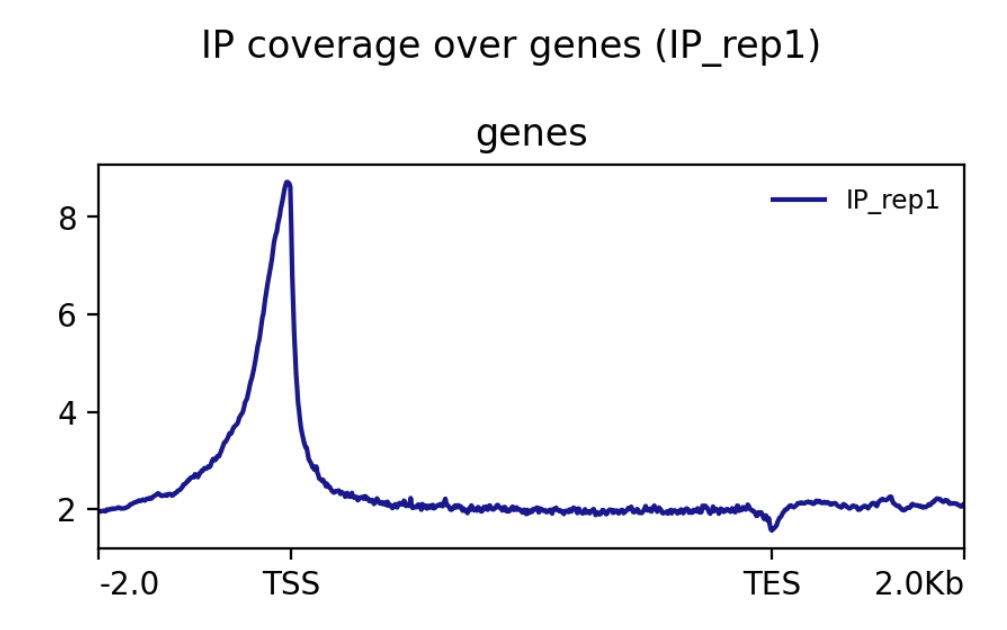
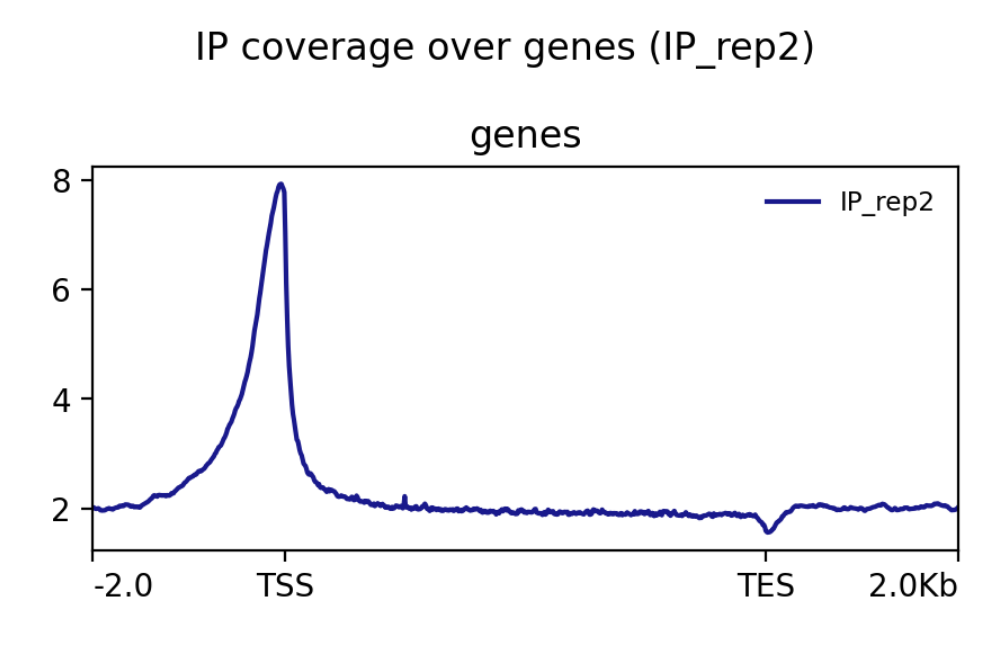
<br>

The signal coverage plots represent the average ChIP-seq read density from the two IP samples across all annotated hg38 genes. Each curve shows how the IP signal is distributed from 2 kb upstream of the transcription start site (TSS), through the scaled gene body, and out to 2 kb transcription end site (TES). Both replicates show a clear and sharp peak at the TSS, with a rapid drop in signal and a relatively flat profile across the rest of the gene body. <br>

This pattern suggests that the immunoprecipitated factor is strongly enriched around promoter regions. The similar shapes of the two replicate profiles indicate good reproducibility, and the low background elsewhere along genes suggests that the IP was specific. Overall, the plots support the idea that this factor primarily binds near transcription start site.

# **Motif Finding** 

Results from the knownResults output from HOMER:
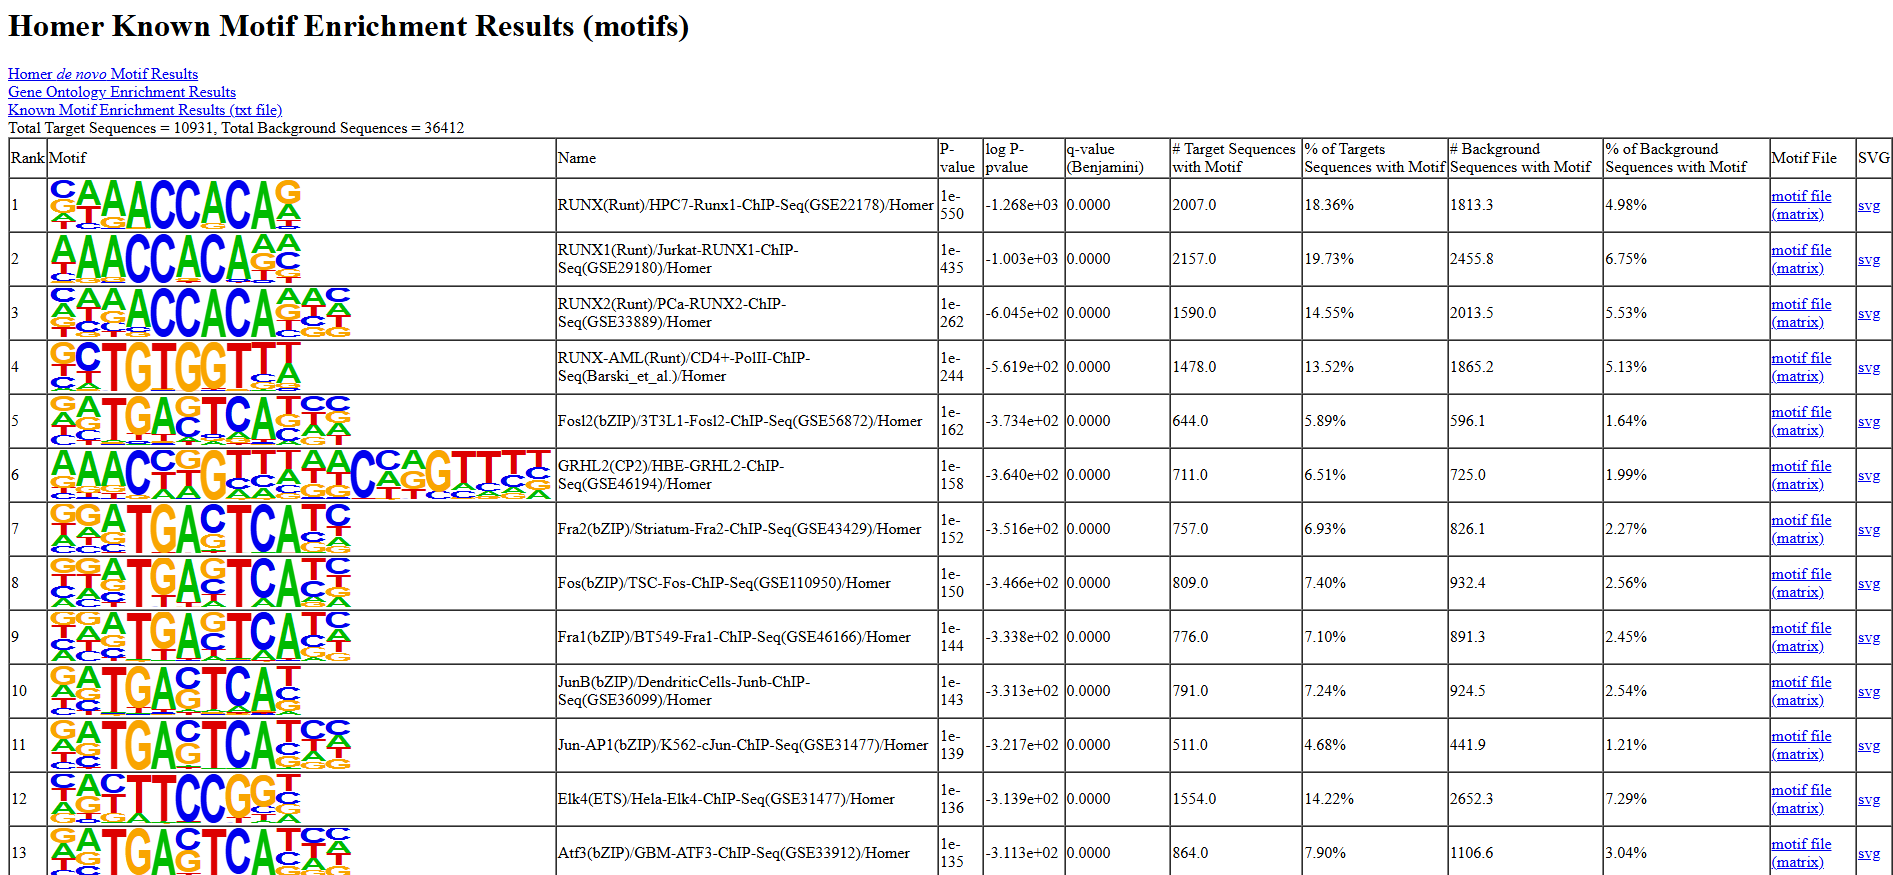

In the motif enrichment results, several RUNX-like motifs appear among the top hits, even though they differ slightly in sequence. This repeated enrichment suggests a consistent and specific binding pattern across the RUNX1 peaks, which fits well with the idea that RUNX1 has a strong preference for its core recognition sequence. The presence of these variants also suggests that the peaks are capturing a real biological signal rather than noise, since multiple independent motifs point back to the same transcription factor.

It’s also interesting that bZIP (FOS/JUN) and ETS family motifs show up in the enriched set. In the paper, the authors mention that RUNX1 can cooperate with these factors, and their motif analysis also highlights similar co-regulatory partners. Seeing these motifs in my data suggests that some RUNX1 binding sites may overlap with regions where these other transcription factors are active. This could mean that the peaks include both direct RUNX1 targets and potential co-regulated sites, which is consistent with the biology described in the study.

# **Overlap your ChIPseq results with the original RNAseq data**

**Focus on the result for figure 2F:**
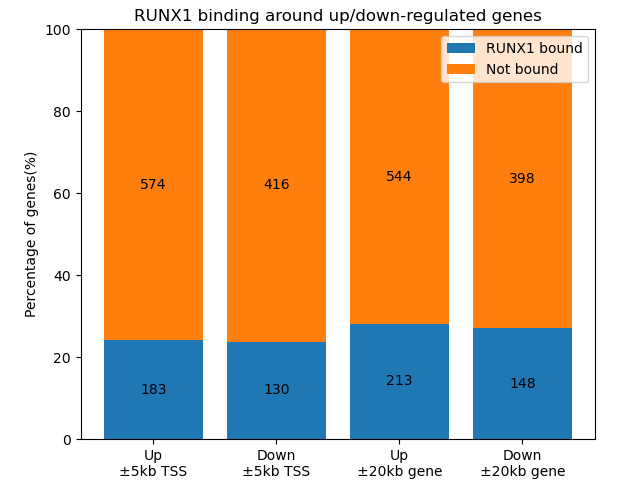
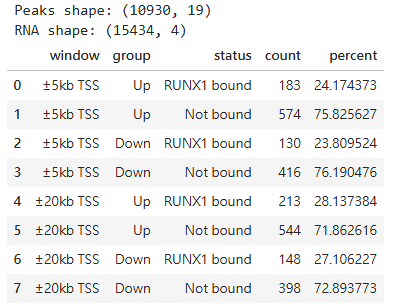 <br>

I applied the same differential expression thresholds as the original publication (padj < 0.05 and |log2FoldChange| > 1), the number of overlapping genes is slightly higher in these results. Several factors likely contribute to thses variations:
 1. Differences in RNA-seq filtering steps
In the publication, the authors likely removed very lowly expressed genes, non-coding genes before calling DEGs. In contrast, our analysis uses the full GEO differential expression table and only applies the padj and log2FC cutoffs, so our DEG list might be slightly larger.
 2. Differences in gene annotation and counting strategy
Our peaks were annotated with HOMER using a gencode v45 (hg38) GTF, whereas the original study was performed on different genome(e.g. hg19). In addition, the counting strategy might also be different, these can change the exact number of up- and down-regulated genes and the number that have a nearby RUNX1 peak.
 3. Differences in window and peak definitions
RUNX1-bound genes were identified using ±5 kb around the TSS and ±20 kb around the gene body based on the dataset’s reproducible peak set. The original figure was generated with the specific promoter definitions and their filtered peak list. Even subtle differences in how windows are defined or which peaks are retained can change the number of genes classified as “RUNX1-bound.”

**Focus on the results for figures 2D and 2E:**
MALAT1(2D)
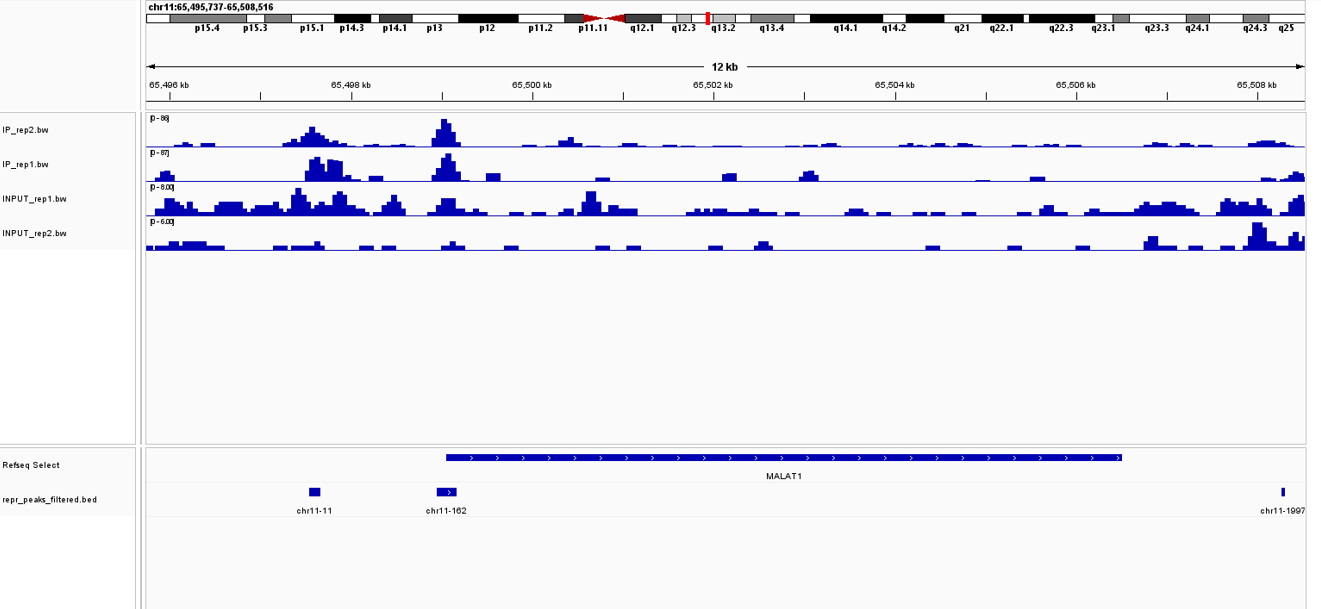

NEAT1(2E)
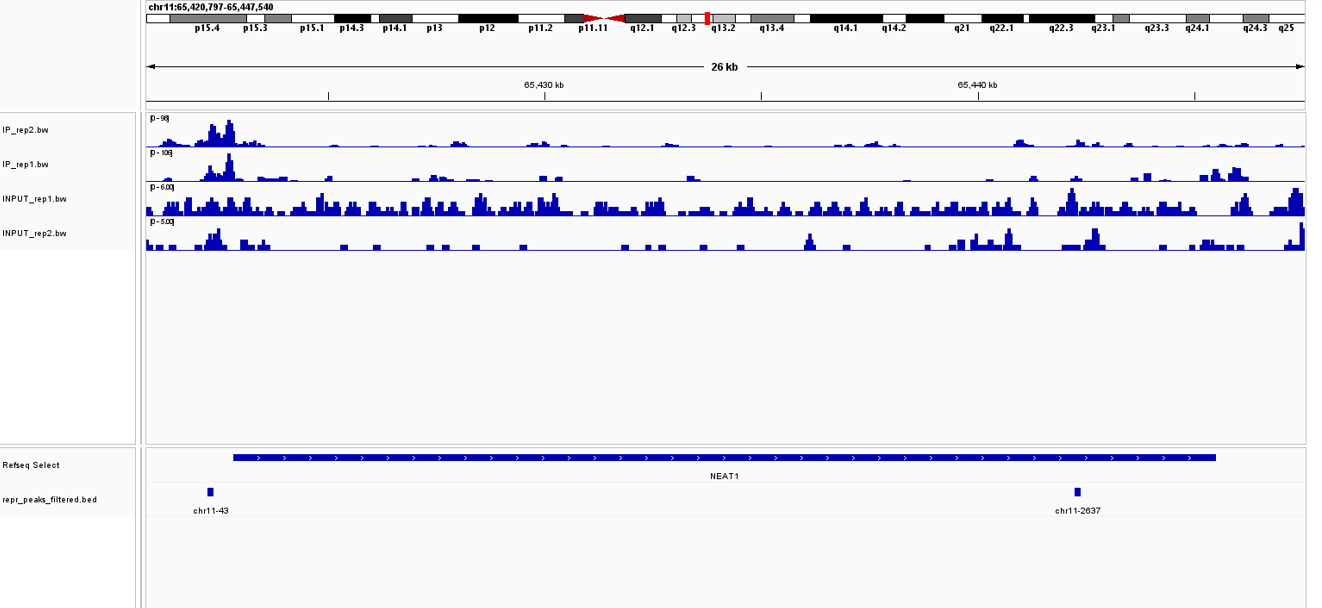

- From the result of annotated peaks, do you observe statistically significant peaks in these same two genes?
- How similar do your genomic tracks appear to those in the paper?
- If you observe any differences, comment briefly on why there may be discrepancies?

Using the result of annotated RUNX1 ChIP-seq peaks for MALAT1 and NEAT1, I observed clear and reproducible enrichment in the IP tracks, while the Input tracks showed only low background signal. These distinct peaks in the IP samples indicate that RUNX1 truly binds near these genomic rgions rather than reflecting random fluctuations or technical artifacts. Even without including RNA-seq tracks, the ChIP-seq profiles alone support the idea that both MALAT1 and NEAT1 are direct RUNX1-associated regions.

While the overall binding patterns correspond well to the published results, the visual appearance of my genomic tracks differs from the paper. The original figures were aligned to hg19, included RNA-seq tracks, and likely involved additional smoothing and normalization steps, whereas my analysis uses hg38 with minimally processed bigWig files. These differences in genome version, data layers, signal scaling, and visualization processing explain why my plots appear simpler. Despite these discrepancies, my results still support the key biological claim: RUNX1 shows reproducible binding at both MALAT1 and NEAT1.

# **Comparing key findings to the original paper**

- **Re-create the table found in supplementary figure S2A.**

| Sample Name | Biological Replicate | Raw Reads | Mapped Reads |
|-------------|----------------------|-----------|--------------|
| IP_rep1     | 1                    | 28,717,962| 27,788,333   |
| IP_rep2     | 2                    | 28,683,573| 28,197,949   |
| INPUT_rep1  | 1                    | 29,738,984| 28,578,769   |
| INPUT_rep2  | 2                    | 10,748,718| 10,055,226   |


When I compared my sequencing statistics with Supplementary Figure S2A, I noticed that the raw and mapped read counts in my IP and Input samples do not match the exact numbers reported in the paper. My samples show similar overall ranges (~28–29M reads for IP and ~10–29M for Input).

These discrepancies are expected for several reasons. First, my analysis was aligned to hg38, whereas the paper aligned to hg19, which might change mapping efficiency. Second, the authors used their own sequencing and preprocessing parameters, while my pipeline follows the workflow with different trimming, filtering, and alignment settings. Small differences in duplicate handling or quality thresholds can also affect the final read counts.
Overall, although the numbers are not identical, my results fall within a reasonable range for a ChIP-seq dataset.

- **Compare your correlation plot with supplementary figure S2B.**
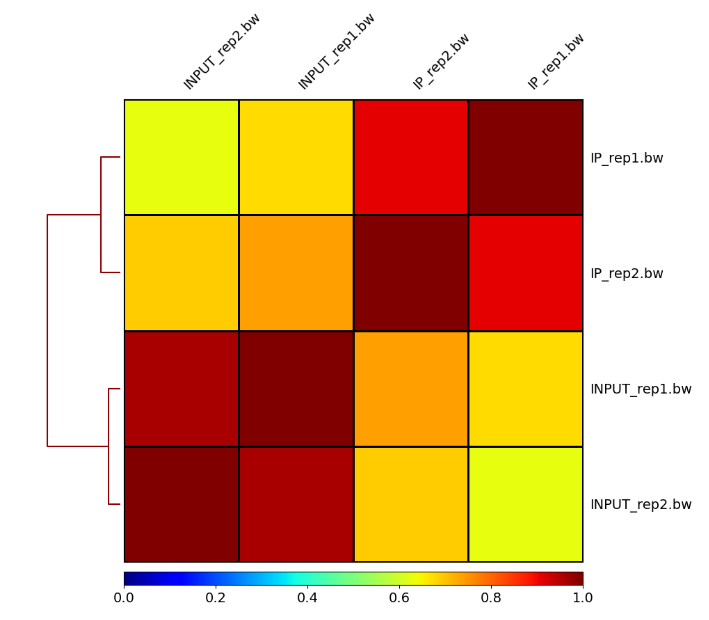

I observed some differences between my correlation plot and the Supplementary Figure S2B, but the overall pattern is consistent. In the paper, both RUNX1 ChIP replicates and input replicates show very high correlations(1.0). My heatmap also shows clear clustering of IP samples together and input samples together, although the exact correlation values are slightly lower, likely due to differences in data processing, normalization, and peak-calling parameters.

The authors used S2B to demonstrate that their replicates were highly reproducible and that the ChIP-seq experiment worked as expected. Based on my result, the same conclusion applies: the IP samples show strong within-group similarity, the inputs cluster together, and IP vs. input signals are clearly separated. This suggests that our dataset is also of good quality and suitable for downstream analysis.

- **Create a venn diagram with the same information in figure S2C.**
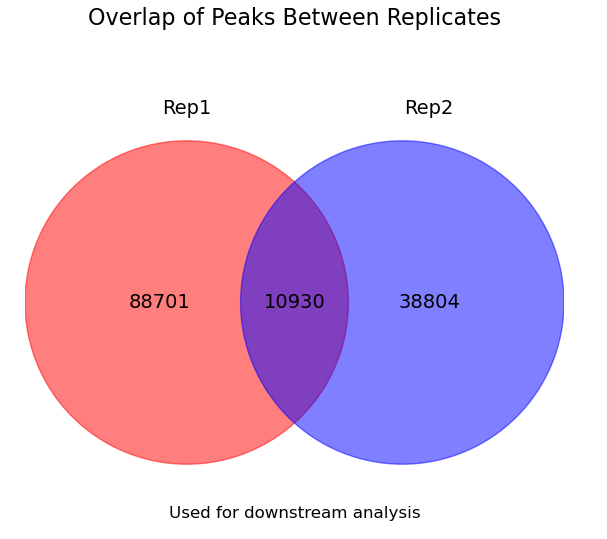

Yes, I did observe differences. My Venn diagram shows a much larger total number of peaks for both replicates (Rep1 ≈ 99k; Rep2 ≈ 49k) compared with the paper (Rep1 = 3,983; Rep2 = 10,465). I also observe a substantial overlap (10,930 shared peaks), the absolute numbers are considerably higher than those reported in S2C.

The discrepancies in the number of called peaks differ might because
 1. Different peak-calling thresholds or parameters.
HOMER’s default settings, FDR, fold change cutoffs, and filtering parameters may differ from those used in the original study, resulting in more permissive peak calls.
 2. Differences in the input data processing pipeline.
Variations in alignment quality, duplicate removal, read filtering, or genome build may influence peak density and lead to larger peak counts.

# **Analyze the annotated peaks** 

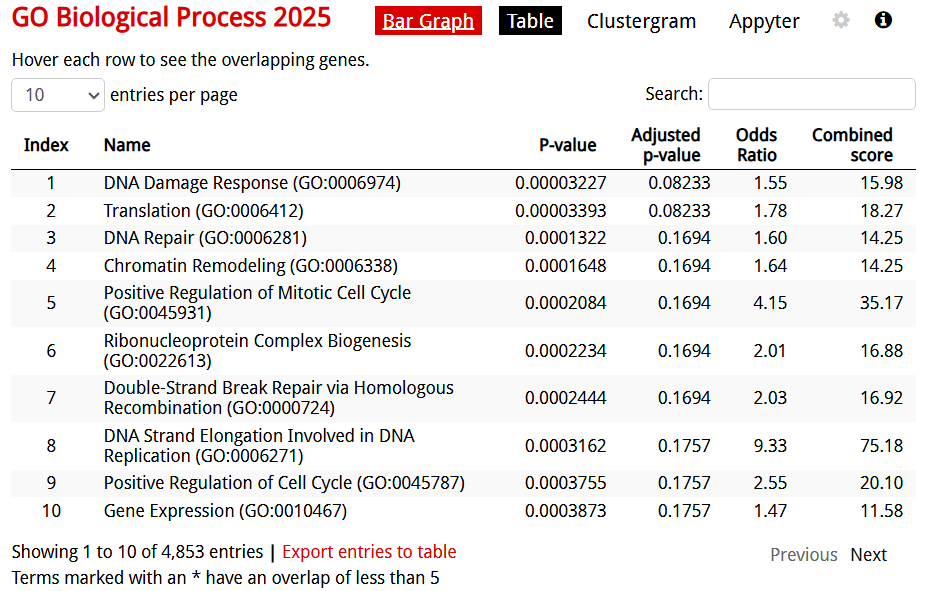
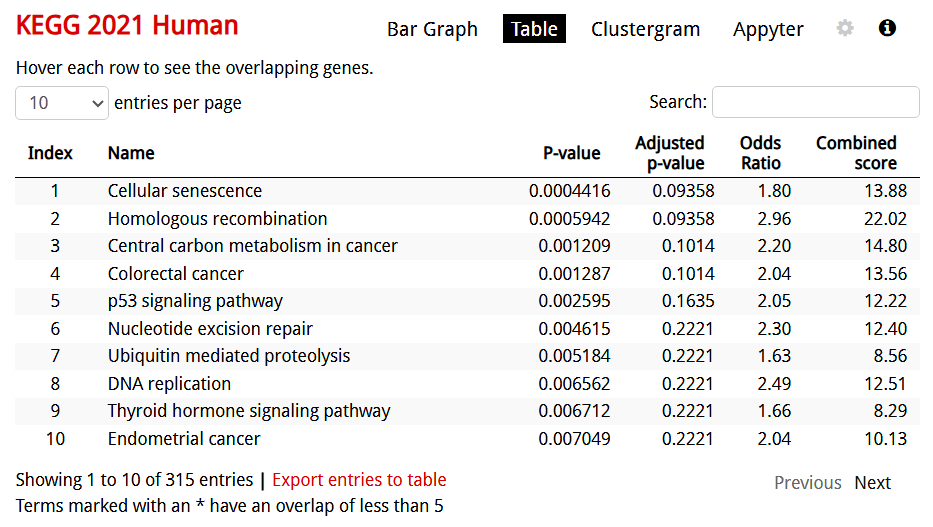

For the peak-based enrichment analysis, I first filtered my annotated RUNX1 ChIP-seq peaks to retain only those located in promoter or TSS regions, because these sites are most likely to represent direct transcriptional targets of RUNX1. I extracted the corresponding gene symbols and submitted this promoter-associated gene list to Enrichr for GO Biological Process 2025 and KEGG 2021 Human enrichment. The top biological processes were strongly enriched for DNA damage response, DNA repair, chromatin remodeling, and cell-cycle regulation, while KEGG terms highlighted pathways such as homologous recombination, p53 signaling, and cancer-related metabolic programs. These results are consistent with the study’s conclusion that RUNX1 plays a regulatory role in genome stability and chromatin organization in MCF-7 cells, suggesting that promoter-bound RUNX1 may directly influence genes involved in maintaining DNA integrity and controlling proliferation.